In [1]:
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Expanded sample data matrix: rows are combinations of classes and languages, columns are classifiers
# Each element is a performance measure (F1-score) for that classifier in that context.
# Assume 3 languages and 4 classes of hate speech, making 12 rows in total
data = np.array([
    [0.861, 0.833, 0.874, 0.888], [0.897, 0.889, 0.904, 0.909], [0.843, 0.823, 0.849, 0.859],  # Class Appropriate in Languages EN, IT, SLO
    [0.391, 0.341, 0.299, 0.367], [0.584, 0.560, 0.554, 0.567], [0.452, 0.433, 0.384, 0.440],  # Class Inappropriate in Languages EN, IT, SLO
    [0.682, 0.650, 0.690, 0.704], [0.604, 0.583, 0.594, 0.600], [0.696, 0.685, 0.684, 0.675],  # Class Offensive in Languages EN, IT, SLO
    [0.278, 0.245, 0.272, 0.266], [0.449, 0.398, 0.387, 0.441], [0.247, 0.238, 0.155, 0.271]   # Class Violent in Languages EN, IT, SLO
])

# Applying the Friedman test
# Unpack each classifier's data across all blocks
stat, p = friedmanchisquare(*data.T)  # Transpose data to align classifiers into separate arrays

print(f'Statistic: {stat}, p-value: {p}')

Statistic: 15.100000000000023, p-value: 0.001733155716624139


In [3]:
# If the Friedman test is significant, perform the Nemenyi test
if p < 0.05:
    print("Significant differences found, performing Nemenyi test.")
    ph = sp.posthoc_nemenyi_friedman(data)
    print(ph)
else:
    print("No significant differences found.")

Significant differences found, performing Nemenyi test.
          0         1         2         3
0  1.000000  0.008516  0.082706  0.900000
1  0.008516  1.000000  0.841401  0.014175
2  0.082706  0.841401  1.000000  0.119675
3  0.900000  0.014175  0.119675  1.000000


Significant Differences: 

between Classifier 0 (Duplicate All) and Classifier 1 (Duplicate Disagreement): 0.008516

between Classifier 1 (Duplicate Disagreement) and Classifier 3 (Duplicate All No Re-weighting): 0.014175

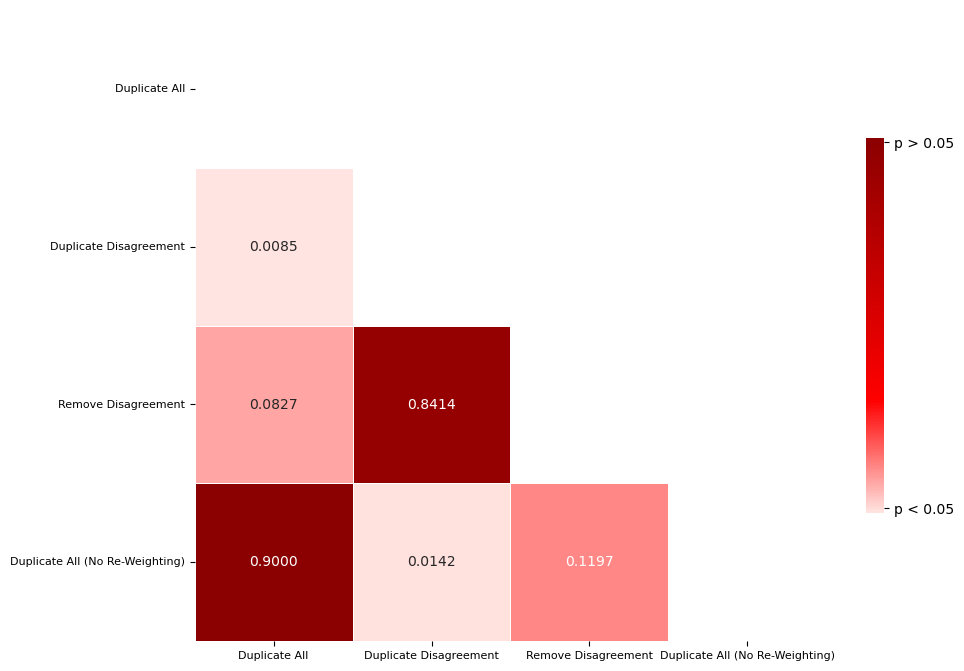

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Assuming p_values is your matrix of p-values from the Nemenyi test
p_values = np.array([
    [1.0000, 0.0085, 0.0827, 0.9000],
    [0.0085, 1.0000, 0.8414, 0.0142],
    [0.0827, 0.8414, 1.0000, 0.1197],
    [0.9000, 0.0142, 0.1197, 1.0000]
])

# Create a custom color palette from green to red
cmap = LinearSegmentedColormap.from_list(
    name='Custom_Grad',
    colors=[
        (0, 'mistyrose'),  # start with green
        (0.30, 'red'),  # an intensified change past the threshold
        (1, 'darkred')  # end with red
    ]
)


# Use np.triu to mask the upper triangle
mask = np.triu(np.ones_like(p_values, dtype=bool))

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(p_values, cmap=cmap, mask=mask, annot=True, fmt=".4f",
                  square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.title('Nemenyi Test Critical Difference Diagram', fontsize=12)
plt.xticks(np.arange(p_values.shape[1]) + 0.5, ['Duplicate All', 'Duplicate Disagreement', 'Remove Disagreement', 'Duplicate All (No Re-Weighting)'], fontsize=8, rotation=0, ha='center')
plt.yticks(np.arange(p_values.shape[0]) + 0.5, ['Duplicate All', 'Duplicate Disagreement', 'Remove Disagreement', 'Duplicate All (No Re-Weighting)'], fontsize=8, rotation=0, va='center')

# Customizing the color bar
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.02, 0.89])
colorbar.set_ticklabels(['p < 0.05', 'p > 0.05'])

plt.tight_layout()
plt.show()